# Import Bibliotek


In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import math
from tqdm import tqdm

import xgboost as xgb
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scikitplot.estimators import plot_learning_curve
import scikitplot as skplt

import matplotlib.pyplot as plt

np.random.seed(0)

# Wczytanie Danych

In [2]:
df = pd.read_excel('Machine_Learning_dataframe.xlsx')
df_Predict = pd.read_excel("Predict_Values.xlsx")
polfabrykat = pd.read_excel("Polfabrykat.xlsx")


In [3]:
df

,IDPart,D,L,Ra,IT,TPO,K0,DBFN,DBMT,DBRG,S,Dsr,Rm,HB,Rodzaj Obrobki,Ilosc obrobek,Kr,re,kc1,material,Ksztalt Plytki,fn_z,vc,kc
0,Part0002,75.00000,110.00000,0.63000,6,0.01800,166.70000,75.23000,76.13000,81.33000,4.52000,84.47000,1000,217,Obrobka Zgrubna,3,75,1.20000,1700,4235,C,0.40000,185.00000,1420.71095
1,Part0002,75.00000,110.00000,0.63000,6,0.01800,166.70000,75.23000,76.13000,81.33000,4.52000,84.47000,1000,217,Obrobka Ksztaltujaca,3,93,0.80000,1700,4235,C,0.13856,285.21711,1099.05276
2,Part0002,80.00000,52.00000,5.00000,12,0.30000,10.00000,80.00000,80.90000,86.10000,4.52000,84.47000,1000,217,Obrobka Zgrubna,2,45,1.20000,1700,4235,C,0.40000,185.00000,1314.13819
3,Part0002,80.00000,52.00000,5.00000,12,0.30000,10.00000,80.00000,80.90000,86.10000,4.52000,84.47000,1000,217,Obrobka Ksztaltujaca,2,93,0.80000,1700,4235,C,0.37523,194.49392,1409.87698
4,Part0002,85.00000,24.00000,0.63000,6,0.02100,142.89999,85.23000,86.13000,91.33000,4.52000,84.47000,1000,217,Obrobka Zgrubna,3,45,1.20000,1700,4235,C,0.40000,185.00000,1314.13819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Part0034,50.00000,61.00000,0.80000,6,0.01600,187.50000,50.24000,50.99000,54.59000,2.96000,58.22000,830,217,Obrobka Ksztaltujaca,3,95,0.80000,1700,2025,C,0.16000,205.00000,1138.59911
242,Part0034,60.00000,47.00000,0.80000,6,0.01800,166.70000,60.24000,60.99000,64.59000,2.96000,58.22000,830,217,Obrobka Zgrubna,3,45,1.20000,1700,2025,C,0.40000,145.00000,1314.13819
243,Part0034,60.00000,47.00000,0.80000,6,0.01800,166.70000,60.24000,60.99000,64.59000,2.96000,58.22000,830,217,Obrobka Ksztaltujaca,3,91,0.80000,1700,2025,C,0.16000,205.00000,1139.64147
244,Part0034,72.00000,15.00000,5.00000,12,0.30000,10.00000,72.00000,72.75000,76.35000,2.96000,58.22000,830,217,Obrobka Zgrubna,2,45,1.20000,1700,2025,C,0.40000,145.00000,1314.13819


# Połączenie danych w celu przypisania indeksów dla kolumn o wartościach nie liczbowych

In [4]:
df_new = pd.concat([df, df_Predict])
df_new = df_new.reset_index(drop=True)


In [5]:
# do usuniecia

#df.info()

df.corr()

,D,L,Ra,IT,TPO,K0,DBFN,DBMT,DBRG,S,Dsr,Rm,HB,Ilosc obrobek,Kr,re,kc1,material,fn_z,vc,kc
D,1.00000,0.49164,0.28196,0.22800,0.37923,0.08913,0.99999,0.99993,0.99966,-0.07339,0.97882,0.69866,0.39870,-0.03193,0.06625,0.00000,0.67351,0.00957,0.07513,-0.41066,0.45672
L,0.49164,1.00000,0.00728,0.08281,0.08780,-0.02767,0.49196,0.49329,0.49488,0.32054,0.48233,0.46122,0.27936,-0.01981,0.05382,0.00000,0.51051,0.02375,0.01801,-0.28164,0.30844
Ra,0.28196,0.00728,1.00000,0.83583,0.91342,-0.55139,0.27978,0.27931,0.28041,-0.18141,0.29373,0.20540,0.14259,-0.62881,-0.04312,0.00000,0.14499,-0.34714,0.18772,-0.32430,0.27387
IT,0.22800,0.08281,0.83583,1.00000,0.90069,-0.80954,0.22512,0.22446,0.22519,-0.13365,0.24073,0.18452,0.18098,-0.83826,-0.03360,0.00000,0.14178,-0.19978,0.16013,-0.26773,0.23880
TPO,0.37923,0.08780,0.91342,0.90069,1.00000,-0.61552,0.37703,0.37689,0.37754,-0.11951,0.38611,0.28956,0.20376,-0.66594,-0.02241,0.00000,0.22064,-0.20594,0.17242,-0.30423,0.29228
K0,0.08913,-0.02767,-0.55139,-0.80954,-0.61552,1.00000,0.09173,0.09215,0.09270,-0.04572,0.11667,0.13165,0.00829,0.77169,0.06228,0.00000,0.07886,0.03901,-0.09916,0.01880,-0.04619
DBFN,0.99999,0.49196,0.27978,0.22512,0.37703,0.09173,1.00000,0.99996,0.99971,-0.07199,0.97879,0.69907,0.39877,-0.02842,0.06634,0.00000,0.67409,0.01072,0.07470,-0.41003,0.45658
DBMT,0.99993,0.49329,0.27931,0.22446,0.37689,0.09215,0.99996,1.00000,0.99986,-0.06843,0.97888,0.69989,0.39997,-0.02745,0.06629,0.00000,0.67535,0.01345,0.07469,-0.40931,0.45723
DBRG,0.99966,0.49488,0.28041,0.22519,0.37754,0.09270,0.99971,0.99986,1.00000,-0.06519,0.98062,0.70152,0.40310,-0.02695,0.06654,0.00000,0.67788,0.01623,0.07549,-0.40828,0.45949
S,-0.07339,0.32054,-0.18141,-0.13365,-0.11951,-0.04572,-0.07199,-0.06843,-0.06519,1.00000,-0.06734,0.13220,0.09901,0.09157,-0.02190,0.00000,0.23596,0.09111,-0.04230,-0.05607,0.06995


# Indeksowanie danych nie liczbowych

In [6]:
y_id, label_id = df_new['IDPart'].factorize()
df_new['IDPart'] = df_new['IDPart'].factorize()[0]


y_rodzaj, label_rodzaj =  df_new['Rodzaj Obrobki'].factorize()
df_new['Rodzaj Obrobki'] = df_new['Rodzaj Obrobki'].factorize()[0]





y_target, label_target = df_new['Ksztalt Plytki'].factorize()
df_new['Ksztalt Plytki'] = df_new['Ksztalt Plytki'].factorize()[0]


y_material, label_material = df_new['material'].factorize()
df_new['material'] = df_new['material'].factorize()[0]

# Rodzielenie danych

In [7]:
df = df_new[ ~df_new['fn_z'].isnull() ].copy()
df_predict = df_new[ df_new['fn_z'].isnull() ].copy()

In [8]:
df

,IDPart,D,L,Ra,IT,TPO,K0,DBFN,DBMT,DBRG,S,Dsr,Rm,HB,Rodzaj Obrobki,Ilosc obrobek,Kr,re,kc1,material,Ksztalt Plytki,fn_z,vc,kc
0,0,75.00000,110.00000,0.63000,6,0.01800,166.70000,75.23000,76.13000,81.33000,4.52000,84.47000,1000,217,0,3.00000,75,1.20000,1700,0,0,0.40000,185.00000,1420.71095
1,0,75.00000,110.00000,0.63000,6,0.01800,166.70000,75.23000,76.13000,81.33000,4.52000,84.47000,1000,217,1,3.00000,93,0.80000,1700,0,0,0.13856,285.21711,1099.05276
2,0,80.00000,52.00000,5.00000,12,0.30000,10.00000,80.00000,80.90000,86.10000,4.52000,84.47000,1000,217,0,2.00000,45,1.20000,1700,0,0,0.40000,185.00000,1314.13819
3,0,80.00000,52.00000,5.00000,12,0.30000,10.00000,80.00000,80.90000,86.10000,4.52000,84.47000,1000,217,1,2.00000,93,0.80000,1700,0,0,0.37523,194.49392,1409.87698
4,0,85.00000,24.00000,0.63000,6,0.02100,142.89999,85.23000,86.13000,91.33000,4.52000,84.47000,1000,217,0,3.00000,45,1.20000,1700,0,0,0.40000,185.00000,1314.13819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,32,50.00000,61.00000,0.80000,6,0.01600,187.50000,50.24000,50.99000,54.59000,2.96000,58.22000,830,217,1,3.00000,95,0.80000,1700,3,0,0.16000,205.00000,1138.59911
242,32,60.00000,47.00000,0.80000,6,0.01800,166.70000,60.24000,60.99000,64.59000,2.96000,58.22000,830,217,0,3.00000,45,1.20000,1700,3,0,0.40000,145.00000,1314.13819
243,32,60.00000,47.00000,0.80000,6,0.01800,166.70000,60.24000,60.99000,64.59000,2.96000,58.22000,830,217,1,3.00000,91,0.80000,1700,3,0,0.16000,205.00000,1139.64147
244,32,72.00000,15.00000,5.00000,12,0.30000,10.00000,72.00000,72.75000,76.35000,2.96000,58.22000,830,217,0,2.00000,45,1.20000,1700,3,0,0.40000,145.00000,1314.13819


# Rozdzielenie kolumn na wejściowe i wyjściowe

In [9]:
black_list_feat = ['kc', 'vc', 'fn_z', 'Ksztalt Plytki', 'DBMT', 'DBRG', 'DBFN', 'Ilosc obrobek', 'IDPart']

all_feats = df.select_dtypes(include=[np.float64, np.int64]).columns

feats_ml = [feat for feat in all_feats if feat not in black_list_feat]


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IDPart          246 non-null    int64  
 1   D               246 non-null    float64
 2   L               246 non-null    float64
 3   Ra              246 non-null    float64
 4   IT              246 non-null    int64  
 5   TPO             246 non-null    float64
 6   K0              246 non-null    float64
 7   DBFN            246 non-null    float64
 8   DBMT            246 non-null    float64
 9   DBRG            246 non-null    float64
 10  S               246 non-null    float64
 11  Dsr             246 non-null    float64
 12  Rm              246 non-null    int64  
 13  HB              246 non-null    int64  
 14  Rodzaj Obrobki  246 non-null    int64  
 15  Ilosc obrobek   246 non-null    float64
 16  Kr              246 non-null    int64  
 17  re              246 non-null    flo

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
IDPart,246.00000,16.82114,10.00166,0.00000,7.25000,16.00000,26.75000,32.00000
D,246.00000,46.41870,31.01687,15.00000,25.00000,40.00000,50.00000,160.00000
L,246.00000,72.90894,81.35802,3.00000,26.25000,47.00000,73.50000,407.00000
Ra,246.00000,1.03423,0.99679,0.32000,0.63000,0.63000,1.25000,5.00000
IT,246.00000,6.65854,1.51633,5.00000,6.00000,6.00000,7.00000,12.00000
TPO,246.00000,0.03514,0.06533,0.00800,0.01300,0.01600,0.02400,0.40000
K0,246.00000,103.12358,41.63131,10.00000,80.00000,111.10000,125.00000,187.50000
DBFN,246.00000,46.68154,31.00282,15.25000,25.40000,40.22000,50.36750,160.00000
DBMT,246.00000,47.59496,31.18974,15.85000,26.45000,40.77000,51.60500,161.85000
DBRG,246.00000,51.12179,32.97375,17.75000,28.65000,43.87000,55.80500,171.65000


In [12]:
df

,IDPart,D,L,Ra,IT,TPO,K0,DBFN,DBMT,DBRG,S,Dsr,Rm,HB,Rodzaj Obrobki,Ilosc obrobek,Kr,re,kc1,material,Ksztalt Plytki,fn_z,vc,kc
0,0,75.00000,110.00000,0.63000,6,0.01800,166.70000,75.23000,76.13000,81.33000,4.52000,84.47000,1000,217,0,3.00000,75,1.20000,1700,0,0,0.40000,185.00000,1420.71095
1,0,75.00000,110.00000,0.63000,6,0.01800,166.70000,75.23000,76.13000,81.33000,4.52000,84.47000,1000,217,1,3.00000,93,0.80000,1700,0,0,0.13856,285.21711,1099.05276
2,0,80.00000,52.00000,5.00000,12,0.30000,10.00000,80.00000,80.90000,86.10000,4.52000,84.47000,1000,217,0,2.00000,45,1.20000,1700,0,0,0.40000,185.00000,1314.13819
3,0,80.00000,52.00000,5.00000,12,0.30000,10.00000,80.00000,80.90000,86.10000,4.52000,84.47000,1000,217,1,2.00000,93,0.80000,1700,0,0,0.37523,194.49392,1409.87698
4,0,85.00000,24.00000,0.63000,6,0.02100,142.89999,85.23000,86.13000,91.33000,4.52000,84.47000,1000,217,0,3.00000,45,1.20000,1700,0,0,0.40000,185.00000,1314.13819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,32,50.00000,61.00000,0.80000,6,0.01600,187.50000,50.24000,50.99000,54.59000,2.96000,58.22000,830,217,1,3.00000,95,0.80000,1700,3,0,0.16000,205.00000,1138.59911
242,32,60.00000,47.00000,0.80000,6,0.01800,166.70000,60.24000,60.99000,64.59000,2.96000,58.22000,830,217,0,3.00000,45,1.20000,1700,3,0,0.40000,145.00000,1314.13819
243,32,60.00000,47.00000,0.80000,6,0.01800,166.70000,60.24000,60.99000,64.59000,2.96000,58.22000,830,217,1,3.00000,91,0.80000,1700,3,0,0.16000,205.00000,1139.64147
244,32,72.00000,15.00000,5.00000,12,0.30000,10.00000,72.00000,72.75000,76.35000,2.96000,58.22000,830,217,0,2.00000,45,1.20000,1700,3,0,0.40000,145.00000,1314.13819


# Klasyfikacja kształtu płytki

In [13]:
def check_model_Shape(df, model_cls, model_params, feats, cv=3,
                      df_predict=df_predict, scoring=accuracy_score, plot_learning_curve=True,
                      plot_confusion_matrix=True, plot_feature_importances=True, save_xgb=False):
    

    X = df[feats]
    y = df['Ksztalt Plytki']
    model = model_cls(**model_params)
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = scoring(y_test, y_pred)
        scores.append(score)
    if save_xgb:
        pickle.dump(model, open("model_ksztalt.json", "wb"))
        print("Model ksztalt został zapisany")         

    result = np.mean(scores), np.std(scores) 

    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X_train, y_train)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X_train, y_train, title=title,figsize=(15, 5), cv=cv, scoring='accuracy');

    if plot_confusion_matrix:
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, title=title, normalize=True, figsize=(10 ,10))

    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5)); 

    return result

# DecisionTreeClassifier dla kształtu plytki

5it [00:00, 140.37it/s]


(0.7033469387755102, 0.03212055591756074)

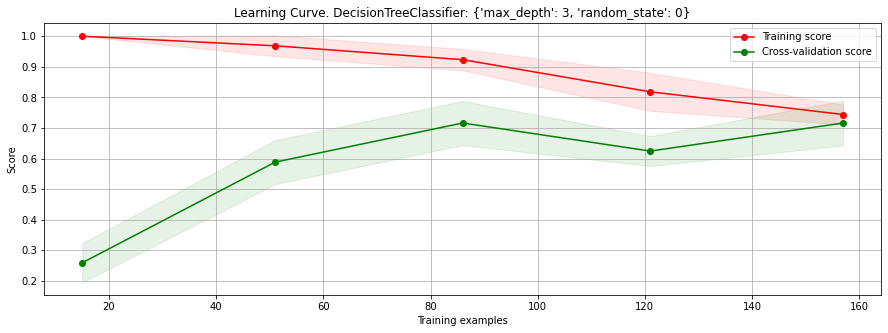

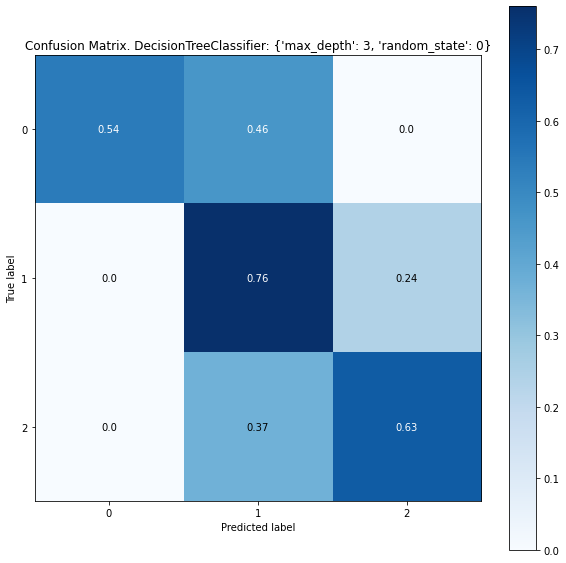

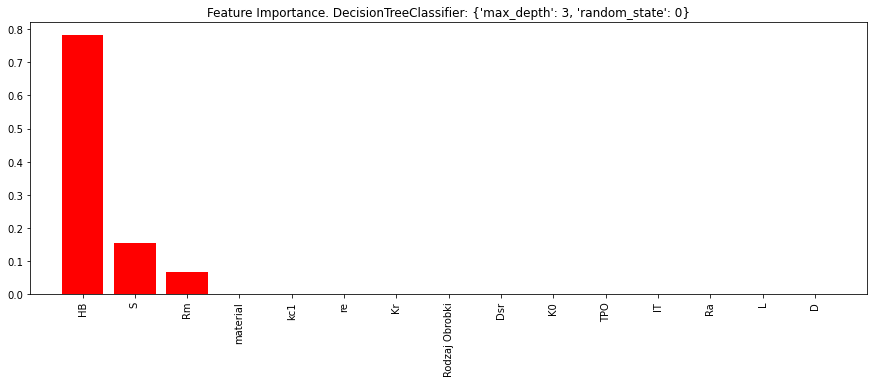

In [14]:
np.random.seed(0)

check_model_Shape(df, DecisionTreeClassifier, {'max_depth': 3, 'random_state': 0}, feats_ml, cv=5, plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True)

# RandomForestClassifier dla kształtu plytki

5it [00:00, 34.88it/s]


(0.7635918367346938, 0.0808230877402618)

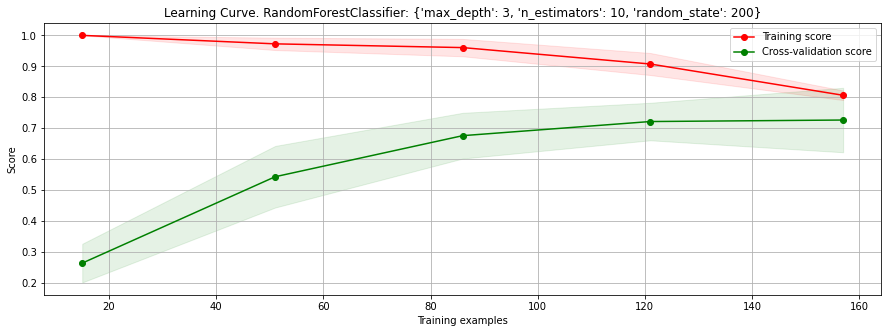

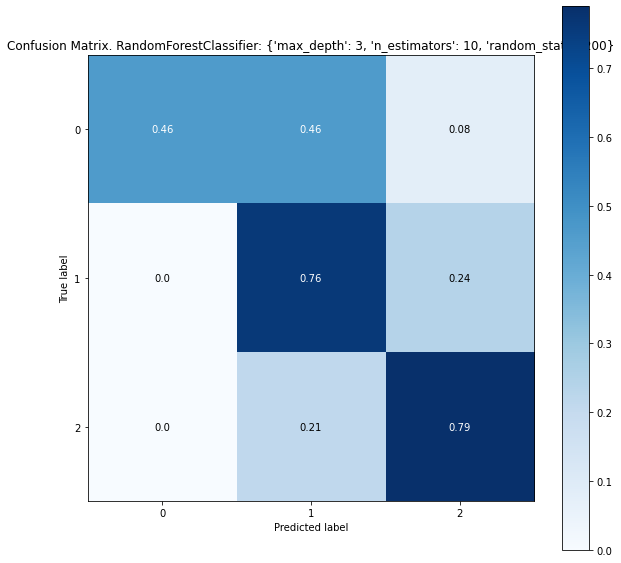

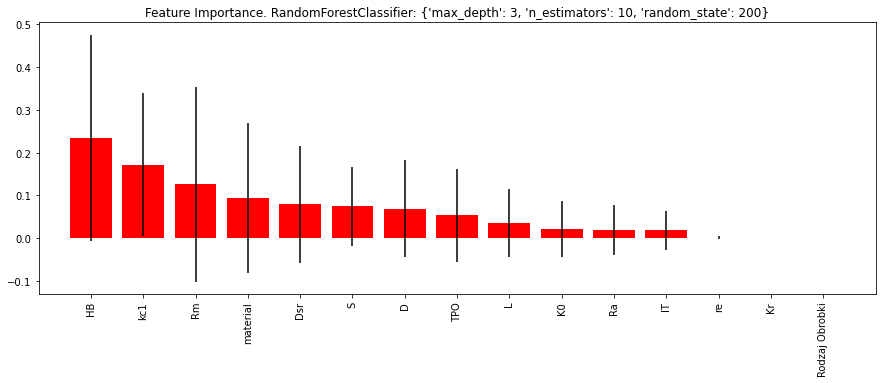

In [15]:
check_model_Shape(df, RandomForestClassifier, {'max_depth': 3,'n_estimators': 10, 'random_state': 200}, feats_ml, cv=5)

 # XGBClassifier dla kształtu plytki

4it [00:00, 18.01it/s]
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/conda/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/conda/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/conda/lib/python3.8/site-packages/xgboost/core.py", line 1367, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/opt/conda/lib

Model ksztalt został zapisany


(0.9310549973558964, 0.041726341152540314)

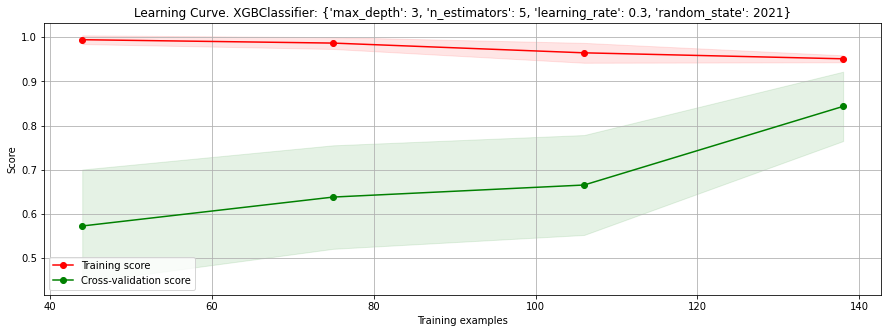

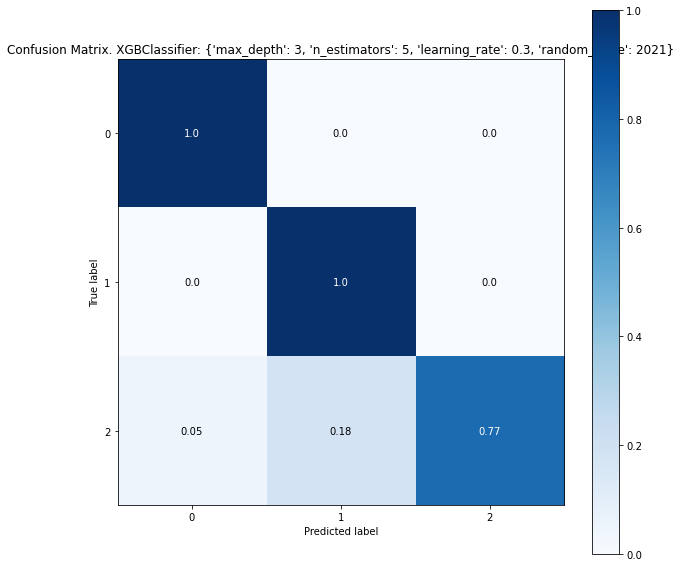

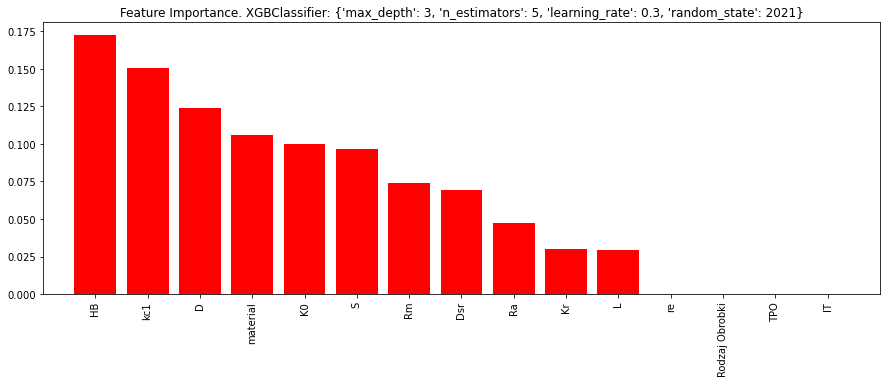

In [16]:
check_model_Shape(df, xgb.XGBClassifier, {'max_depth': 3,'n_estimators': 5, 'learning_rate': 0.3, 'random_state': 2021}, feats_ml, cv=4, save_xgb=True)


In [17]:
def check_model_Ilosc_obrobek(df, model_cls, model_params, feats, cv=3, df_predict=df_predict, scoring=accuracy_score, plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True, save_xgb=False):
    
    X = df[feats]
    y = df['Ilosc obrobek']


    model = model_cls(**model_params)

    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = scoring(y_test, y_pred)
        scores.append(score)
    if save_xgb:
        pickle.dump(model, open("model_ilosc_obrobek.json", "wb"))
        print("Model ilosc_obrobek został zapisany")         

    result = np.mean(scores), np.std(scores) 
    
    

    model = None
    if plot_learning_curve:
        model = model_cls(**model_params)
        model.fit(X_train, y_train)
        title='Learning Curve. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_learning_curve(model, X_train, y_train, title=title,figsize=(15, 5), cv=cv, scoring='accuracy');

    if plot_confusion_matrix:
        title='Confusion Matrix. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, title=title, normalize=True, figsize=(10 ,10))

    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5)); 

    return result

# Dane wejściowe dla klasyfikacji ilości obróbek

In [18]:
feats_ml_ilosc_df = df[['TPO','IT']]

feats_ml_ilosc = feats_ml_ilosc_df.select_dtypes(include=[np.float64, np.int64]).columns




# DecisionTreeClassifier dla ilosci obrobek

5it [00:00, 151.78it/s]


(0.9592653061224489, 0.03166926123949257)

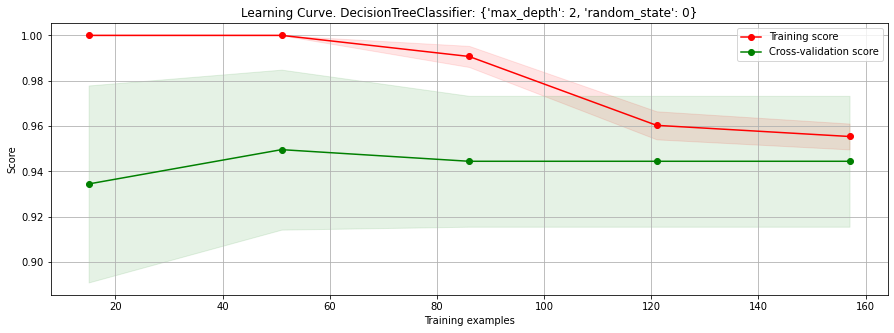

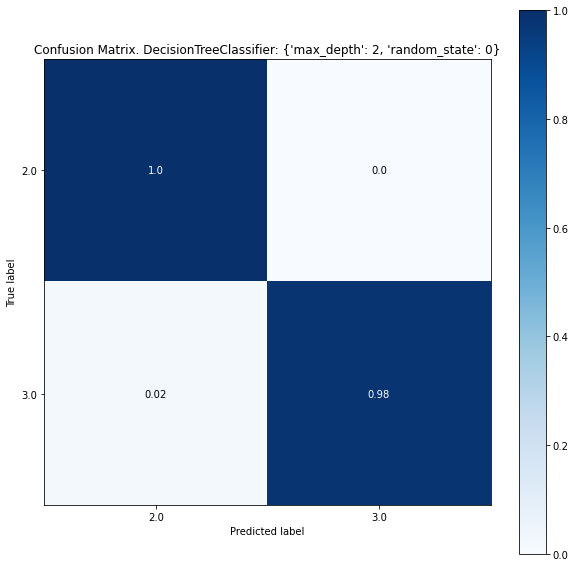

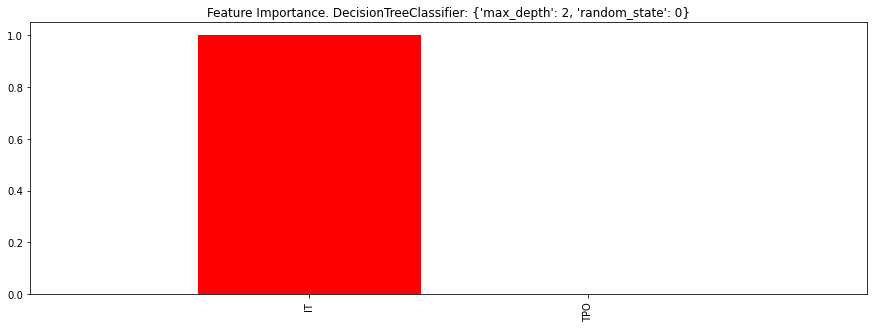

In [19]:
check_model_Ilosc_obrobek(df, DecisionTreeClassifier, {'max_depth': 2, 'random_state': 0}, feats_ml_ilosc, cv=5, plot_learning_curve=True, plot_confusion_matrix=True, plot_feature_importances=True)

# RandomForestClassifier dla ilosci obrobek

5it [00:00, 41.52it/s]


(0.9470204081632654, 0.027779581041935675)

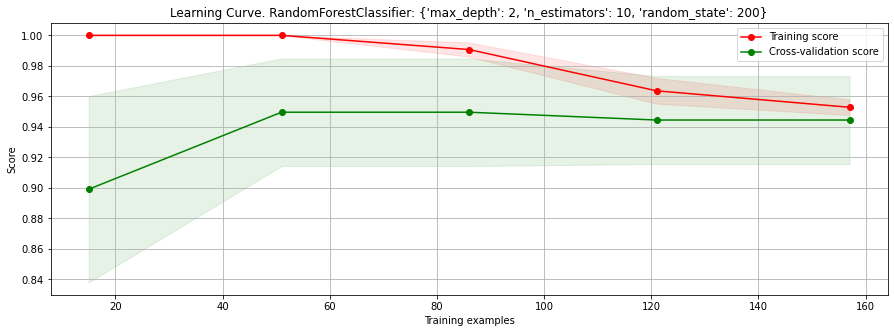

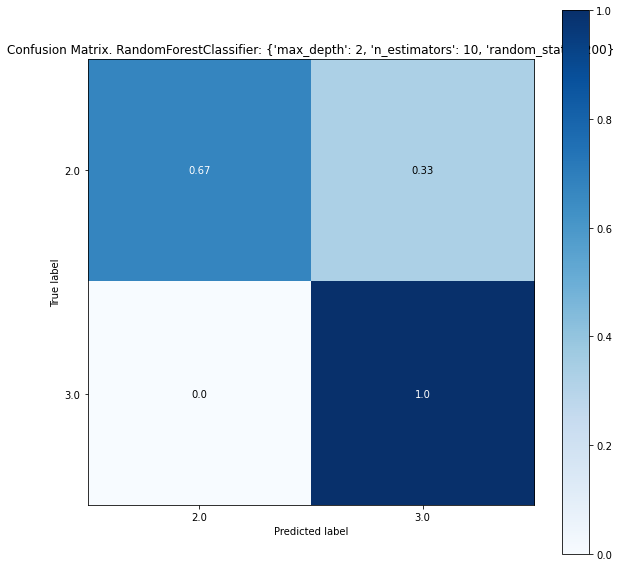

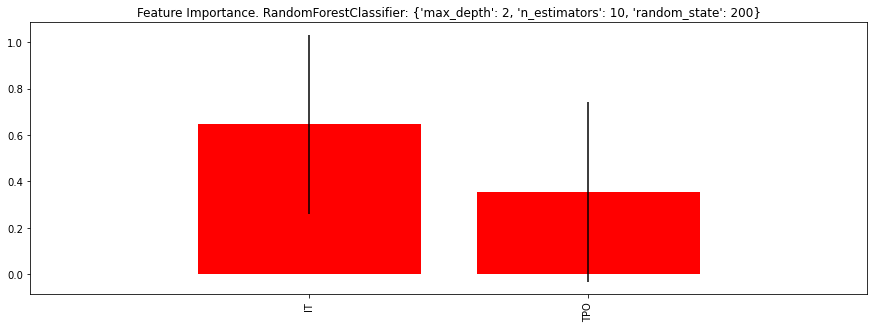

In [20]:
check_model_Ilosc_obrobek(df, RandomForestClassifier, {'max_depth': 2,'n_estimators': 10, 'random_state': 200}, feats_ml_ilosc, cv=5)


# XGBClassifier dla ilości obróbek

5it [00:00, 34.07it/s]


Model ilosc_obrobek został zapisany


(0.9592653061224489, 0.03166926123949257)

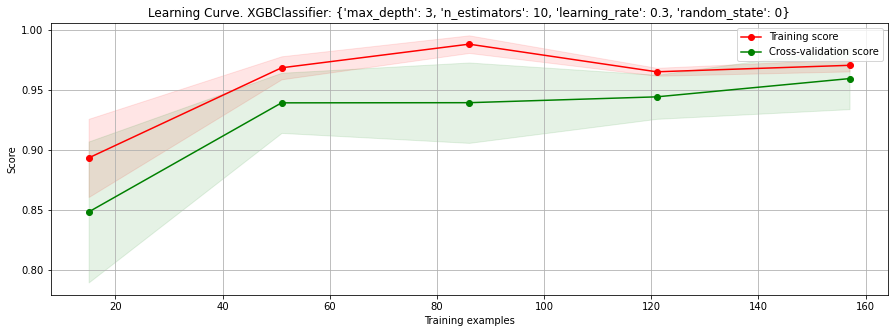

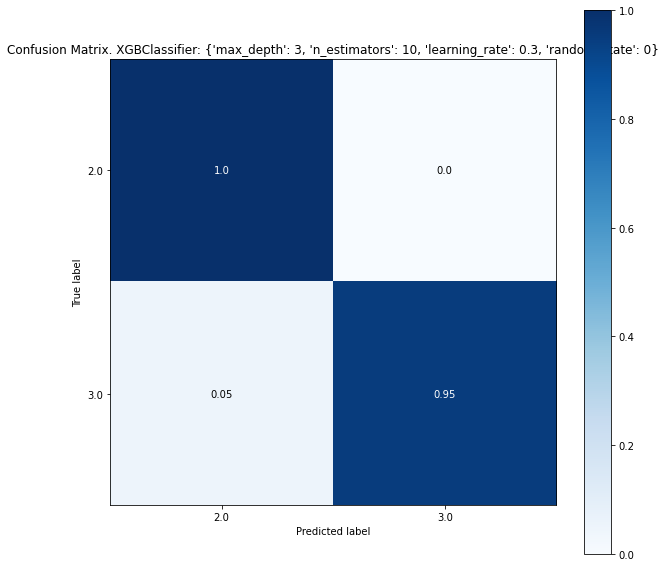

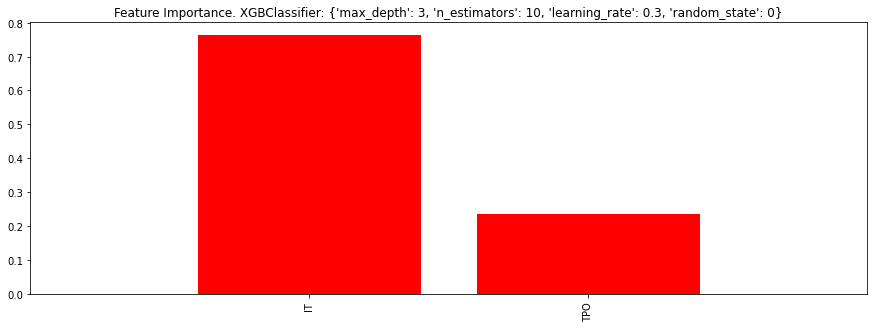

In [21]:
check_model_Ilosc_obrobek(df, xgb.XGBClassifier, {'max_depth': 3,'n_estimators': 10, 'learning_rate': 0.3, 'random_state': 0}, feats_ml_ilosc, cv=5, save_xgb=True)


# Regresja fn

In [22]:
def check_model_Regression_fn(df, model_cls, model_params, feats, cv=5, scoring=mean_absolute_error, plot_learning_curve=True, plot_feature_importances=True, save_xgb=False):
    
        
    X = df[feats]
    y = df['fn_z']


    model = model_cls(**model_params)



    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)       
        score = scoring(y_test, y_pred)

        scores.append(score)

    if save_xgb:
        pickle.dump(model, open("model_fn.json", "wb"))
        print("Model fn został zapisany")            

    result = np.mean(scores), np.std(scores) 


    if plot_learning_curve:
        skplt.estimators.plot_learning_curve(model_cls(**model_params), X_train, y_train, cv=cv);


    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));



    return result

# DecisionTreeRegressor dla fn

5it [00:00, 159.60it/s]


(0.03425614893432023, 0.0028218038134010474)

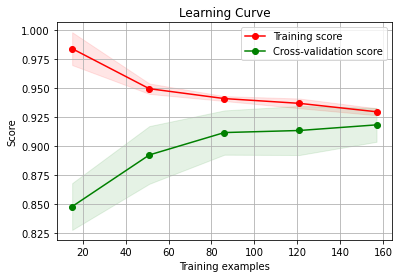

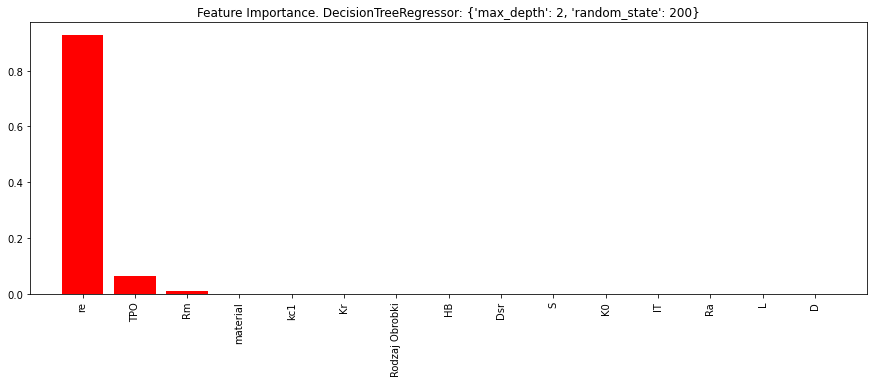

In [23]:
check_model_Regression_fn(df, DecisionTreeRegressor, {'max_depth': 2, 'random_state': 200}, feats_ml, cv=5)

# RandomForestRegressor dla fn

5it [00:00, 69.41it/s]


(0.03480342137102971, 0.0025609427751137875)

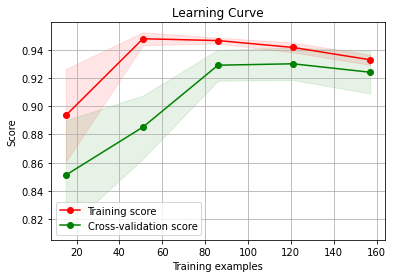

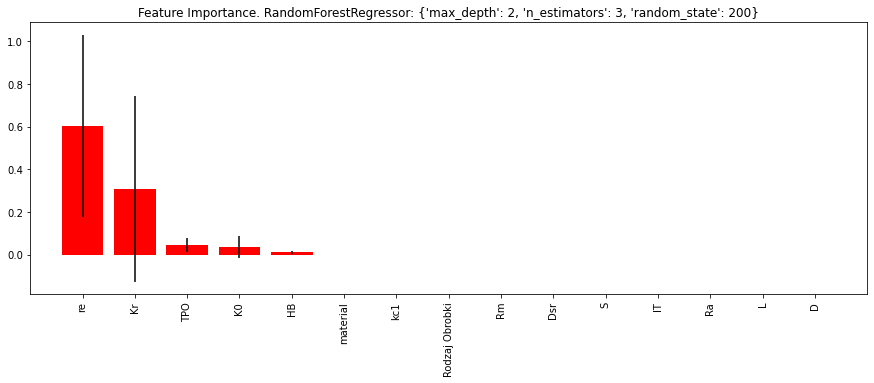

In [24]:
check_model_Regression_fn(df, RandomForestRegressor, {'max_depth': 2,'n_estimators': 3, 'random_state': 200}, feats_ml, cv=5, plot_learning_curve=True, plot_feature_importances=True)

# XGBRegressor dla fn

5it [00:00, 31.11it/s]


Model fn został zapisany


(0.029243028535678218, 0.003603676353664958)

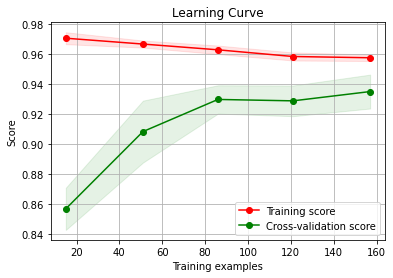

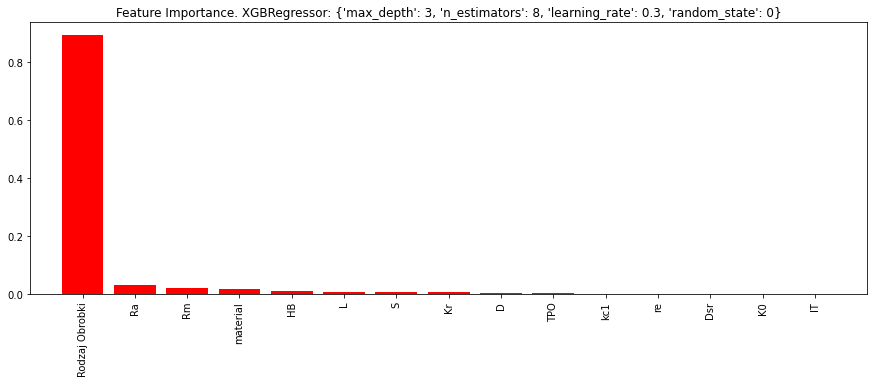

In [25]:
check_model_Regression_fn(df, xgb.XGBRegressor, {'max_depth': 3,'n_estimators': 8, 'learning_rate': 0.3, 'random_state': 0}, feats_ml, cv=5, save_xgb=True)

# Regresja vc

In [26]:
def check_model_Regression_vc(df, model_cls, model_params, feats, cv=5, scoring=mean_absolute_error, plot_learning_curve=True, plot_feature_importances=True, save_xgb=False):
    
        
    X = df[feats]
    y = df['vc']


    model = model_cls(**model_params)



    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)       
        score = scoring(y_test, y_pred)

        scores.append(score)

    if save_xgb:
        pickle.dump(model, open("model_vc.json", "wb"))
        print("Model vc został zapisany")            

    result = np.mean(scores), np.std(scores) 


    if plot_learning_curve:
        skplt.estimators.plot_learning_curve(model_cls(**model_params), X_train, y_train, cv=cv);


    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));

    return result

# DecisionTreeRegressor dla vc

5it [00:00, 153.17it/s]


(63.725654068087366, 4.5603587239885695)

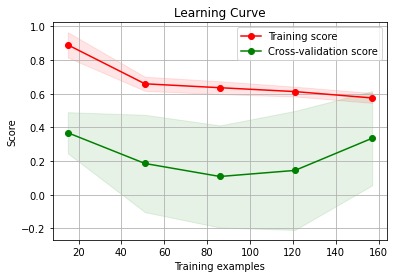

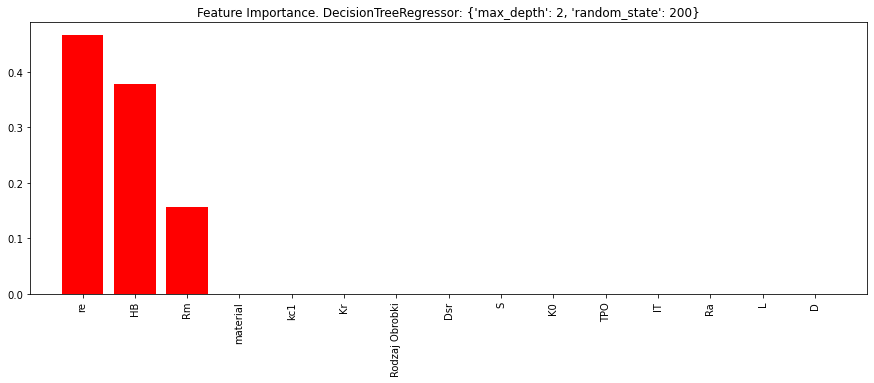

In [27]:
check_model_Regression_vc(df, DecisionTreeRegressor, {'max_depth': 2, 'random_state': 200}, feats_ml, cv=5)

# RandomForestRegressor dla vc

5it [00:00, 83.53it/s]


(58.98682233172624, 3.70861237450834)

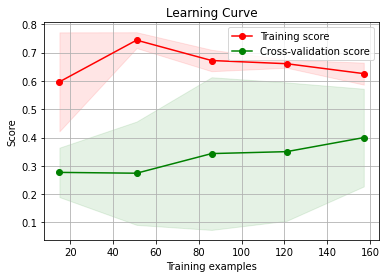

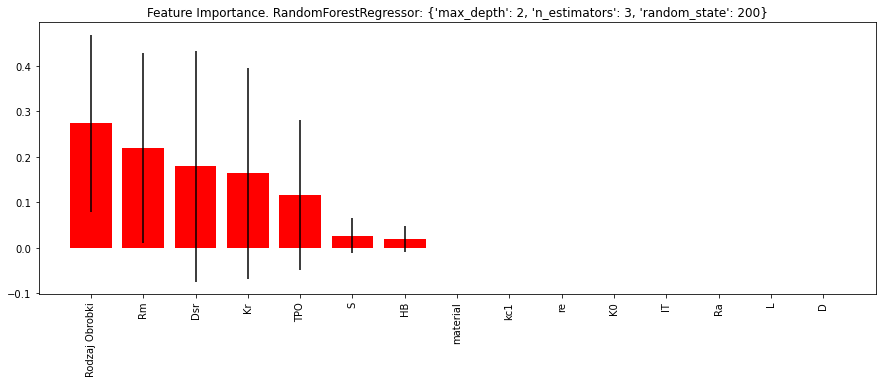

In [28]:
check_model_Regression_vc(df, RandomForestRegressor, {'max_depth': 2,'n_estimators': 3, 'random_state': 200}, feats_ml, cv=5, plot_learning_curve=True, plot_feature_importances=True)

# XGBRegressor dla vc

4it [00:00, 46.27it/s]


Model vc został zapisany


(14.507872103001265, 1.6544945073886068)

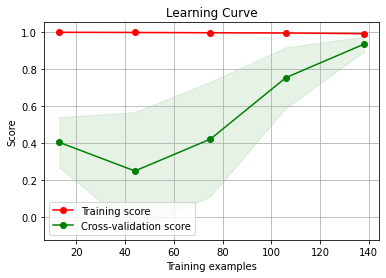

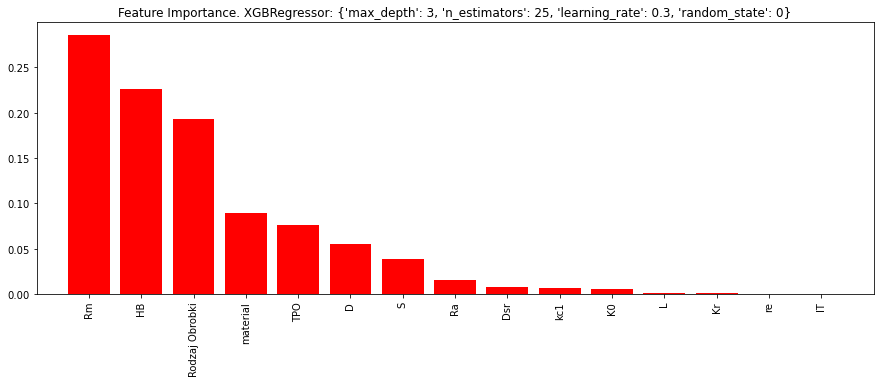

In [29]:
check_model_Regression_vc(df, xgb.XGBRegressor, {'max_depth': 3,'n_estimators': 25, 'learning_rate': 0.3, 'random_state': 0}, feats_ml, cv=4, save_xgb=True)

# Regresja Kc

In [30]:
def check_model_Regression_kc(df, model_cls, model_params, feats, cv=5, scoring=mean_absolute_error, plot_learning_curve=True, plot_feature_importances=True, save_xgb=False):
    
        
    X = df[feats]
    y = df['kc']


    model = model_cls(**model_params)


    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)       
        score = scoring(y_test, y_pred)

        scores.append(score)

    if save_xgb:
        pickle.dump(model, open("model_kc.json", "wb"))
        print("Model Kc został zapisany")            

    result = np.mean(scores), np.std(scores) 


    if plot_learning_curve:
        skplt.estimators.plot_learning_curve(model_cls(**model_params), X_train, y_train, cv=cv);


    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));

    return result

# DecisionTreeRegressor dla kc

5it [00:00, 160.92it/s]


(31.62892371027877, 7.129126738087308)

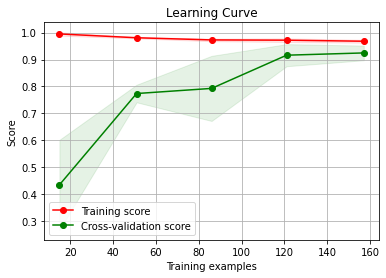

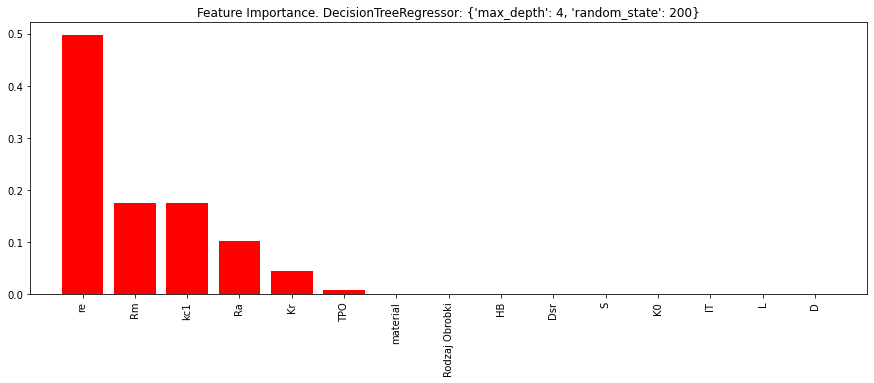

In [31]:
check_model_Regression_kc(df, DecisionTreeRegressor, {'max_depth': 4, 'random_state': 200}, feats_ml, cv=5)

# RandomForestRegressor dla kc


5it [00:00, 82.39it/s]


(33.94129276613609, 3.364566745743269)

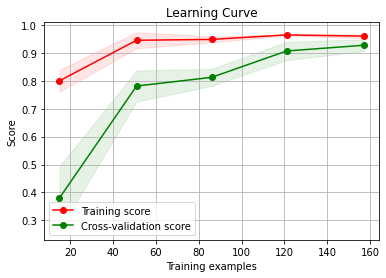

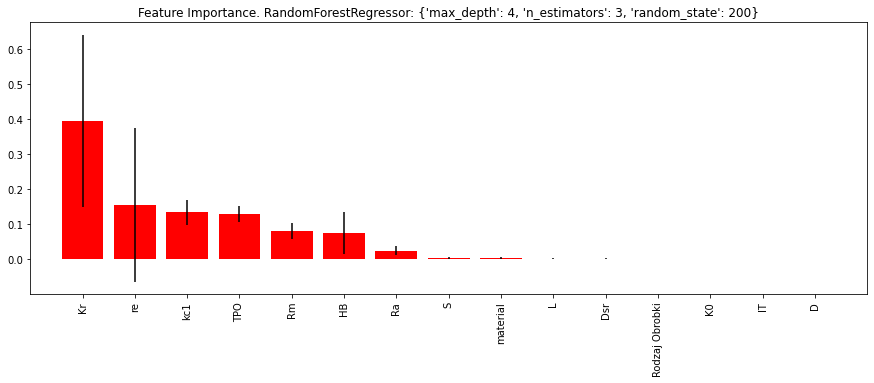

In [32]:
check_model_Regression_kc(df, RandomForestRegressor, {'max_depth': 4,'n_estimators': 3, 'random_state': 200}, feats_ml, cv=5, plot_learning_curve=True, plot_feature_importances=True)

# XGBRegressor dla kc

5it [00:00, 13.49it/s]


Model Kc został zapisany


(23.155971451953764, 2.313676306573243)

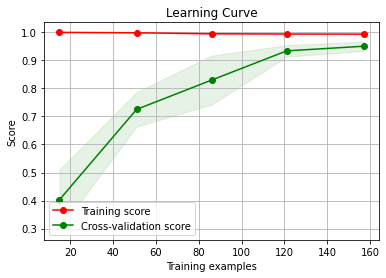

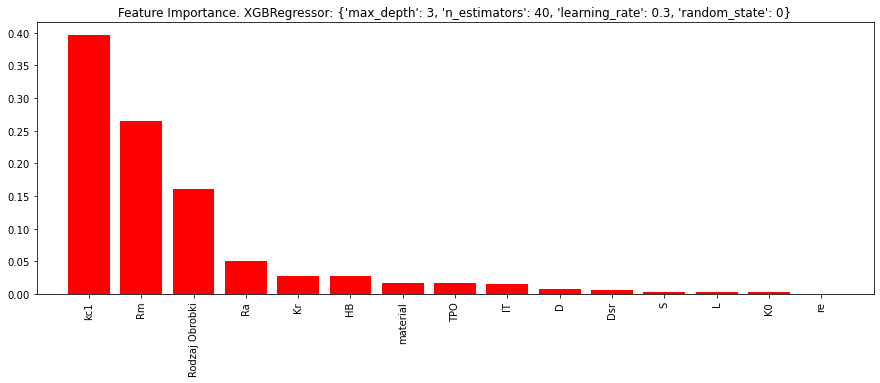

In [33]:
check_model_Regression_kc(df, xgb.XGBRegressor, {'max_depth': 3,'n_estimators': 40, 'learning_rate': 0.3, 'random_state': 0}, feats_ml, cv=5, save_xgb=True)

# Regresja DBMT

In [34]:
def check_model_Regression_DBMT(df, model_cls, model_params, feats, cv=5, scoring=mean_absolute_error, plot_learning_curve=True, plot_feature_importances=True, save_xgb=False):
    
        
    X = df[feats]
    y = df['DBMT']


    model = model_cls(**model_params)



    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)       
        score = scoring(y_test, y_pred)

        scores.append(score)

    if save_xgb:
        pickle.dump(model, open("model_DBMT.json", "wb"))
        print("Model DBMT został zapisany")            

    result = np.mean(scores), np.std(scores) 


    if plot_learning_curve:
        skplt.estimators.plot_learning_curve(model_cls(**model_params), X_train, y_train, cv=cv);


    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));

    return result

# DecisionTreeRegressor dla DBMT

5it [00:00, 151.80it/s]


(1.5769566996778601, 0.3385451191469661)

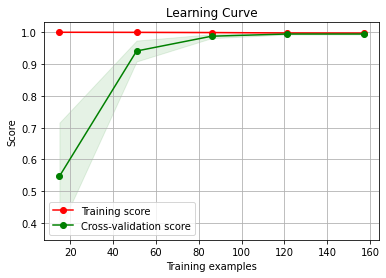

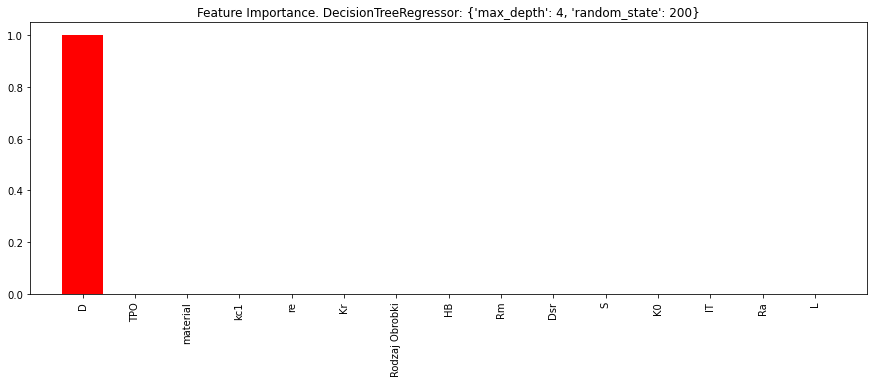

In [35]:
check_model_Regression_DBMT(df, DecisionTreeRegressor, {'max_depth': 4, 'random_state': 200}, feats_ml, cv=5)

# RandomForestRegressor dla DBMT

5it [00:00, 85.07it/s]


(1.6439195896387102, 0.48601143089643983)

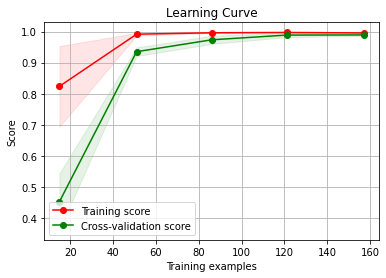

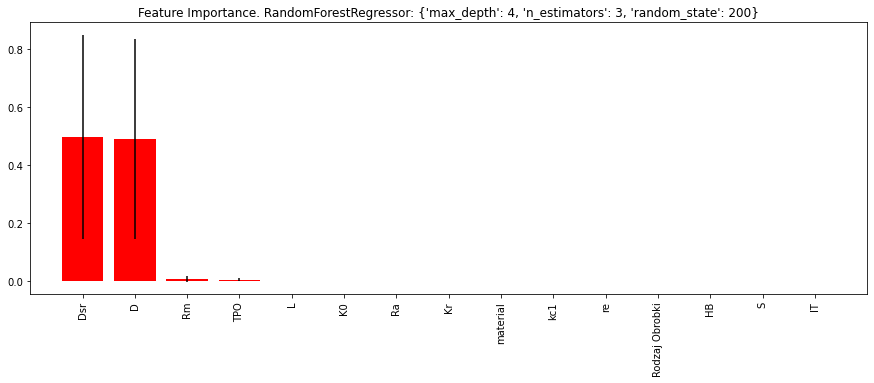

In [36]:
check_model_Regression_DBMT(df, RandomForestRegressor, {'max_depth': 4,'n_estimators': 3, 'random_state': 200}, feats_ml, cv=5, plot_learning_curve=True, plot_feature_importances=True)

# XGBRegressor dla DBMT

5it [00:00, 25.62it/s]


Model DBMT został zapisany


(0.4150514132067622, 0.16910186757182816)

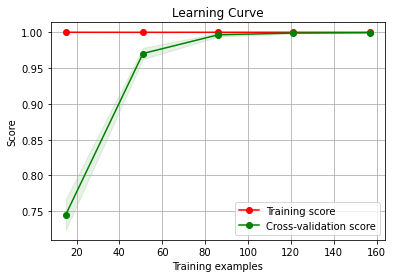

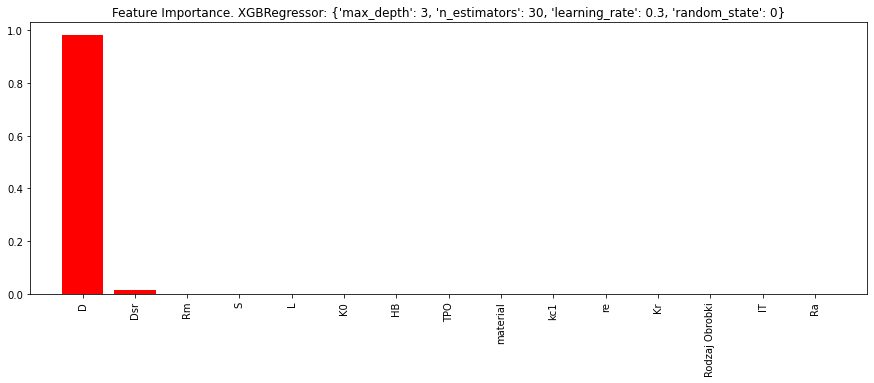

In [37]:
check_model_Regression_DBMT(df, xgb.XGBRegressor, {'max_depth': 3,'n_estimators': 30, 'learning_rate': 0.3, 'random_state': 0}, feats_ml, cv=5, save_xgb=True)

# Regresja DBRG

In [38]:
def check_model_Regression_DBRG(df, model_cls, model_params, feats, cv=5, scoring=mean_absolute_error, plot_learning_curve=True, plot_feature_importances=True, save_xgb=False):
    
        
    X = df[feats]
    y = df['DBRG']


    model = model_cls(**model_params)

    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)       
        score = scoring(y_test, y_pred)

        scores.append(score)

    if save_xgb:
        pickle.dump(model, open("model_DBRG.json", "wb"))
        print("Model DBRG został zapisany")            

    result = np.mean(scores), np.std(scores) 


    if plot_learning_curve:
        skplt.estimators.plot_learning_curve(model_cls(**model_params), X_train, y_train, cv=cv);


    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));

    return result

# DecisionTreeRegressor dla DBRG

5it [00:00, 151.10it/s]


(1.866135102596024, 0.29204089338481387)

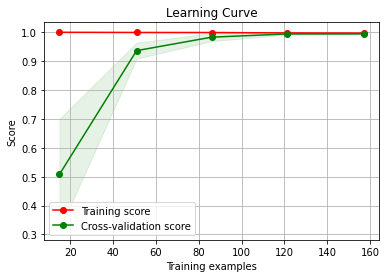

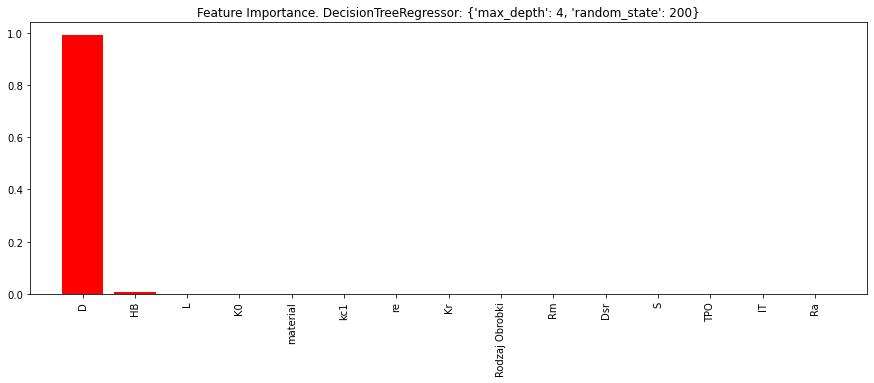

In [39]:
check_model_Regression_DBRG(df, DecisionTreeRegressor, {'max_depth': 4, 'random_state': 200}, feats_ml, cv=5)

# RandomForestRegressor dla DBRG

5it [00:00, 51.47it/s]


(1.9866590017147536, 0.30158279393790066)

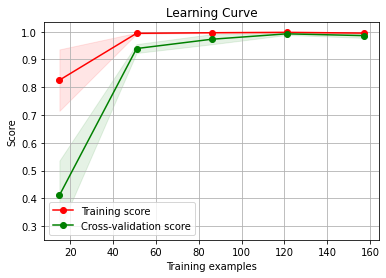

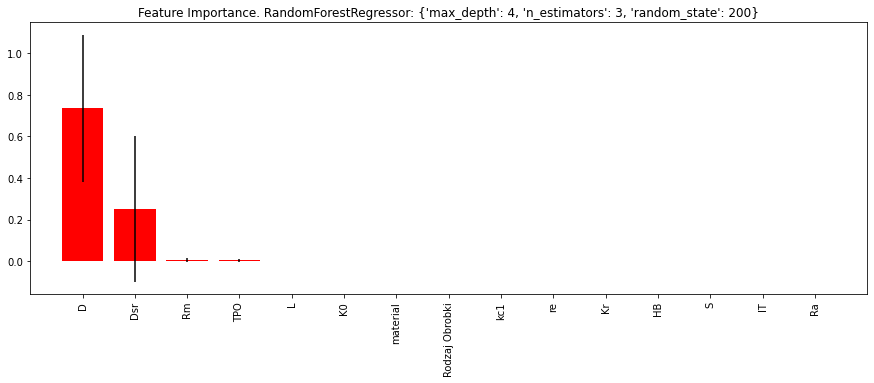

In [40]:
check_model_Regression_DBRG(df, RandomForestRegressor, {'max_depth': 4,'n_estimators': 3, 'random_state': 200}, feats_ml, cv=5, plot_learning_curve=True, plot_feature_importances=True)

# XGBRegressor dla DBRG

5it [00:00, 24.02it/s]


Model DBRG został zapisany


(0.807864467262735, 0.1580044332655383)

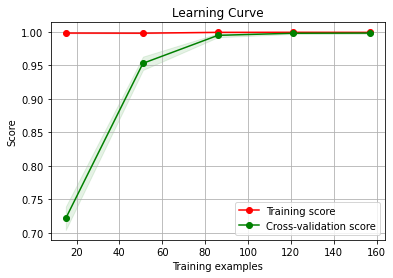

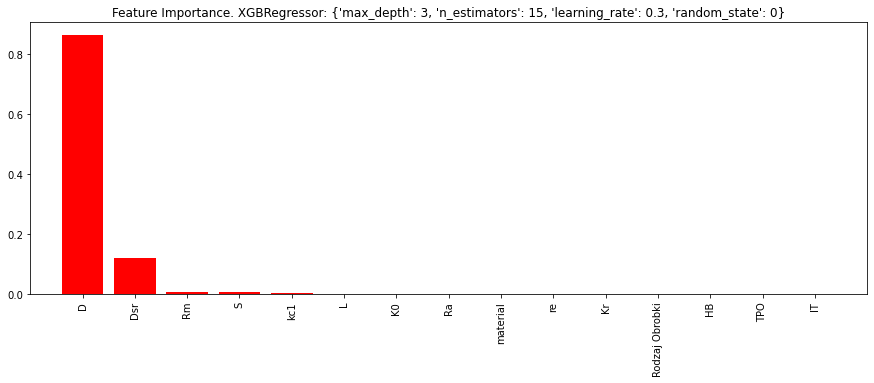

In [41]:
check_model_Regression_DBRG(df, xgb.XGBRegressor, {'max_depth': 3,'n_estimators': 15, 'learning_rate': 0.3, 'random_state': 0}, feats_ml, cv=5, save_xgb=True)

# Regresja DBFN

In [42]:
def check_model_Regression_DBFN(df, model_cls, model_params, feats, cv=5, scoring=mean_absolute_error, plot_learning_curve=True, plot_feature_importances=True, save_xgb=False):
    
        
    X = df[feats]
    y = df['DBFN']


    model = model_cls(**model_params)


    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)       
        score = scoring(y_test, y_pred)

        scores.append(score)

    if save_xgb:
        pickle.dump(model, open("model_DBFN.json", "wb"))
        print("Model DBFN został zapisany")            

    result = np.mean(scores), np.std(scores) 


    if plot_learning_curve:
        skplt.estimators.plot_learning_curve(model_cls(**model_params), X_train, y_train, cv=cv);


    if plot_feature_importances:
        if model is None:
            model = model_cls(**model_params)
            model.fit(X_train, y_train)
        title='Feature Importance. {0}: {1}'.format(model_cls.__name__, model_params)
        skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));

    return result

# DecisionTreeRegressor dla DBFN

5it [00:00, 125.60it/s]


(1.6112868917710792, 0.36789070294850584)

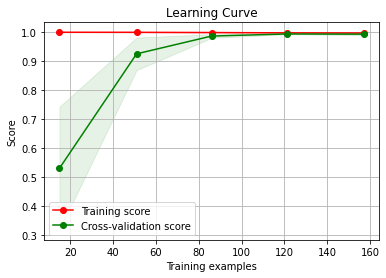

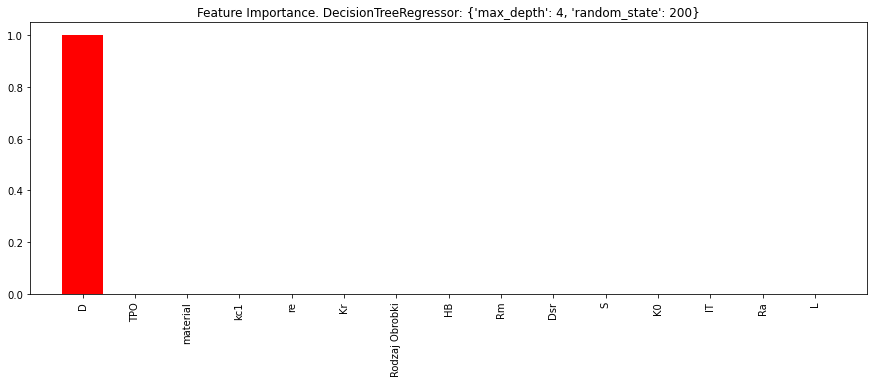

In [43]:
check_model_Regression_DBFN(df, DecisionTreeRegressor, {'max_depth': 4, 'random_state': 200}, feats_ml, cv=5)

# RandomForestRegressor dla DBFN

5it [00:00, 75.41it/s]


(1.4754609987997616, 0.3165018784626533)

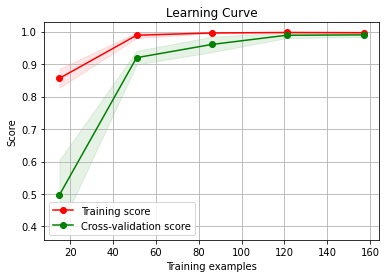

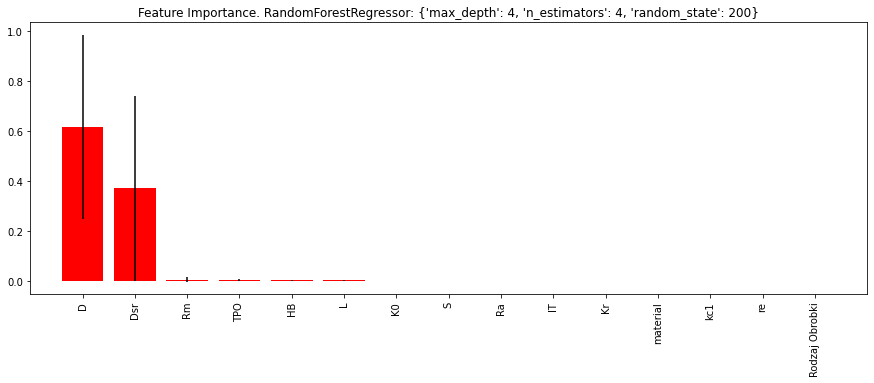

In [44]:
check_model_Regression_DBFN(df, RandomForestRegressor, {'max_depth': 4,'n_estimators': 4, 'random_state': 200}, feats_ml, cv=5, plot_learning_curve=True, plot_feature_importances=True)

# XGBRegressor  dla DBFN

4it [00:00, 15.17it/s]


Model DBFN został zapisany


(0.3802147799783888, 0.280082779796395)

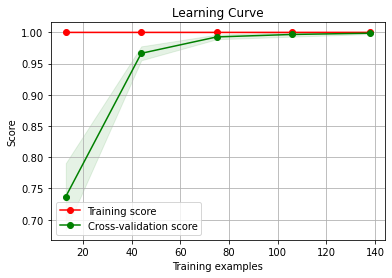

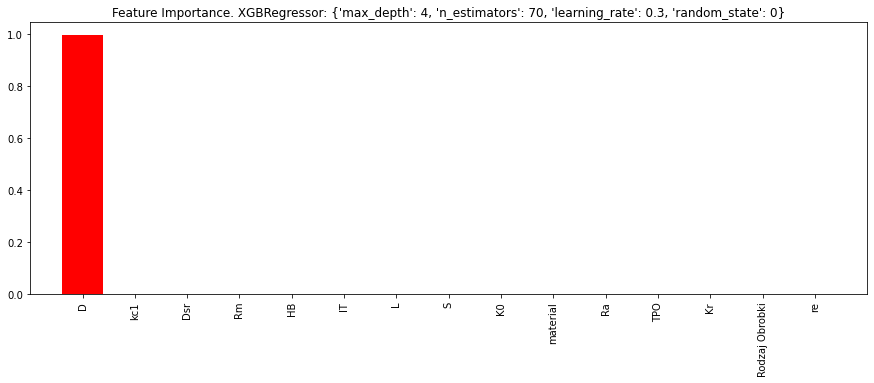

In [45]:
check_model_Regression_DBFN(df, xgb.XGBRegressor, {'max_depth': 4,'n_estimators': 70, 'learning_rate': 0.3, 'random_state': 0}, feats_ml, cv=4, save_xgb=True)

# Wczytanie modeli oraz wyznaczenie parametrów

In [46]:
df_predict = df_predict.reset_index()
if 'index' in df_predict:
    del df_predict['index']
    
df_predict['Ilosc obrobek'] = np.nan
    
loaded_model_ilosc = pickle.load(open("model_ilosc_obrobek.json", "rb"))        
loaded_model_ksztalt = pickle.load(open("model_ksztalt.json", "rb"))
loaded_model_fn = pickle.load(open("model_fn.json", "rb"))
loaded_model_vc = pickle.load(open("model_vc.json", "rb"))
loaded_model_kc = pickle.load(open("model_kc.json", "rb"))
loaded_model_DBMT = pickle.load(open("model_DBMT.json", "rb"))
loaded_model_DBRG = pickle.load(open("model_DBRG.json", "rb"))
loaded_model_DBFN = pickle.load(open("model_DBFN.json", "rb"))






In [47]:

df_predict['Ilosc obrobek'] = loaded_model_ilosc.predict(df_predict[feats_ml_ilosc])
df_predict['Ksztalt Plytki'] = loaded_model_ksztalt.predict(df_predict[feats_ml])
df_predict['fn_z'] = loaded_model_fn.predict(df_predict[feats_ml])
df_predict['vc'] = loaded_model_vc.predict(df_predict[feats_ml])
df_predict['kc'] = loaded_model_kc.predict(df_predict[feats_ml])
df_predict['DBMT'] = loaded_model_DBMT.predict(df_predict[feats_ml])
df_predict['DBRG'] = loaded_model_DBRG.predict(df_predict[feats_ml])
df_predict['DBFN'] = loaded_model_DBFN.predict(df_predict[feats_ml])


for indeks0 in range(0, df_predict.shape[0]):
    if df_predict['Ilosc obrobek'][indeks0] == 2:
        df_predict['DBFN'][indeks0] = df_predict['D'][indeks0]


<ipython-input-47-970418c45997>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['DBFN'][indeks0] = df_predict['D'][indeks0]


# Obliczenie parametrów oraz utworzenie pliku

In [48]:

df_predict['Rodzaj Obrobki'] = label_rodzaj[df_predict['Rodzaj Obrobki']]
df_predict['material'] = label_material[df_predict['material']]
df_predict['IDPart'] = label_id[df_predict['IDPart']]
df_predict['Ksztalt Plytki'] = label_target[df_predict['Ksztalt Plytki']]

df_predict['fn_z'] = df_predict['fn_z'].map(lambda x: round(x, 3))
df_predict['vc'] = df_predict['vc'].map(lambda x: round(x, 3))
df_predict['DBMT'] = df_predict['DBMT'].map(lambda x: round(x, 2))
df_predict['DBRG'] = df_predict['DBRG'].map(lambda x: round(x, 2))
df_predict['kc'] = df_predict['kc'].map(lambda x: round(x, 3))
df_predict['DBFN'] = df_predict['DBFN'].map(lambda x: round(x, 2))

df_predict = df_predict.reset_index()
if 'index' in df_predict:
    del df_predict['index']

df_predict['DPF'] = np.nan 

df_predict['Ilosc obrobek'] = df_predict['Ilosc obrobek'].astype(int)

IDPart = 0
for indeks3_df in range(0, df_predict.shape[0]):
    if df_predict['IDPart'][indeks3_df] == IDPart:

        df_predict['DPF'][indeks3_df] = Value_DPF
                  
    else:   
        IDPart = df_predict['IDPart'][indeks3_df]
        df_part = df_predict.loc[
                        (df_predict['IDPart'] == IDPart)
                        ]
        df_part = df_part.sort_values(['DBRG'], ignore_index = True, ascending=False)
        DBRG_value = df_part['DBRG'][0]
        for indeks2 in range(0, polfabrykat.shape[0]-1):
            if DBRG_value > polfabrykat['D'][indeks2] and DBRG_value <= polfabrykat['D'][indeks2+1]:
                Value_DPF = polfabrykat['D'][indeks2+1]
                df_predict['DPF'][indeks3_df] = Value_DPF
                break
        

df_predict['ap'] = np.nan
df_predict['ilosc przejsc'] = np.nan
df_predict['tg'] = np.nan 





for indeks_df in range(0, df_predict.shape[0]):
    if df_predict['Rodzaj Obrobki'][indeks_df] == 'Obrobka Ksztaltujaca':
        df_predict['ap'][indeks_df] = round((df_predict['DBMT'][indeks_df] - df_predict['DBFN'][indeks_df]) / 2,3)
        df_predict['tg'][indeks_df] = round((df_predict['L'][indeks_df] * df_predict['DBFN'][indeks_df] * 60) / (318 * df_predict['vc'][indeks_df] * df_predict['fn_z'][indeks_df]),3)
        
    else:
        df_predict['ap'][indeks_df] = round((df_predict['DPF'][indeks_df] - df_predict['DBMT'][indeks_df]) / 2,3)
        df_predict['tg'][indeks_df] = round((df_predict['L'][indeks_df] * df_predict['DBMT'][indeks_df] * 60) / (318 * df_predict['vc'][indeks_df] * df_predict['fn_z'][indeks_df]),3)



df_predict['n'] = round((1000 * df_predict['vc']) / (math.pi * df_predict['DPF']),3)
df_predict['Q'] = round(df_predict['vc'] * df_predict['fn_z'] * df_predict['ap'],3)
df_predict['hm'] = df_predict['Kr'].map(lambda x: math.sin(x * math.pi/180))
df_predict['hm'] = round(df_predict['hm'] * df_predict['fn_z'],3)
df_predict['Fc'] = round(df_predict['kc'] * df_predict['fn_z'] * df_predict['ap'],3)
df_predict['Pc'] = round(((df_predict['kc'] * df_predict['fn_z'] * df_predict['ap'] * df_predict['vc']) / 60000) ,3)

df_predict = df_predict[ [ col for col in df_predict.columns if col != 'tg' ] + ['tg']] #zapisanie kolumny tg jako ostatniej


for indeks4_df in range(0, df_predict.shape[0]):
    df_predict['ilosc przejsc'][indeks4_df] = 1
    ap_rzeczywiste =  df_predict['ap'][indeks4_df]
    while df_predict['Pc'][indeks4_df] > 20:
        df_predict['ilosc przejsc'][indeks4_df] = df_predict['ilosc przejsc'][indeks4_df] +1
        df_predict['ap'] = df_predict['ap'].astype(float)
        df_predict['ap'][indeks4_df] = round(ap_rzeczywiste / df_predict['ilosc przejsc'][indeks4_df],3)
        df_predict['Pc'][indeks4_df] = round((df_predict['kc'][indeks4_df] * df_predict['fn_z'][indeks4_df] * df_predict['ap'][indeks4_df] * df_predict['vc'][indeks4_df]) / 60000, 3)
        df_predict['Pc'] = df_predict['Pc'].astype(float)
        df_predict['Q'][indeks4_df] = round(df_predict['vc'][indeks4_df] * df_predict['fn_z'][indeks4_df] * df_predict['ap'][indeks4_df], 3)
        df_predict['Fc'][indeks4_df] = round(df_predict['kc'][indeks4_df] * df_predict['fn_z'][indeks4_df] * df_predict['ap'][indeks4_df], 3)



df_predict.to_excel("Dane.xlsx")
print("Twoje parametry zostały obliczone i zapisane w pliku: Dane.xlsx")

Twoje parametry zostały obliczone i zapisane w pliku: Dane.xlsx


<ipython-input-48-550218c8c024>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['DPF'][indeks3_df] = Value_DPF
<ipython-input-48-550218c8c024>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['DPF'][indeks3_df] = Value_DPF
<ipython-input-48-550218c8c024>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_predict['ap'][indeks_df] = round((df_predict['DPF'][indeks_df] - df_predict['DBMT'][indeks_df]) / 2,3)
<ip

In [49]:
df_predict

,IDPart,D,L,Ra,IT,TPO,K0,DBFN,DBMT,DBRG,S,Dsr,Rm,HB,Rodzaj Obrobki,Ilosc obrobek,Kr,re,kc1,material,Ksztalt Plytki,fn_z,vc,kc,DPF,ap,ilosc przejsc,n,Q,hm,Fc,Pc,tg
0,Part0001,38.00000,80.00000,0.63000,6,0.01600,100.00000,40.26000,41.07000,44.37000,5.17000,40.85000,420,140,Obrobka Zgrubna,3,60,1.20000,1500,4235,T,0.44100,269.08200,1265.73800,50.00000,4.46500,1.00000,1713.02900,529.84000,0.38200,2492.32000,11.17700,5.22400
1,Part0001,38.00000,80.00000,0.63000,6,0.01600,100.00000,40.26000,41.07000,44.37000,5.17000,40.85000,420,140,Obrobka Ksztaltujaca,3,95,0.80000,1500,4235,T,0.16000,410.82000,988.97200,50.00000,0.40500,1.00000,2615.36100,26.62100,0.15900,64.08500,0.43900,9.24500
2,Part0001,40.00000,33.00000,1.25000,8,0.03900,41.00000,40.00000,41.17000,44.37000,5.17000,40.85000,420,140,Obrobka Zgrubna,2,60,1.20000,1500,4235,T,0.44100,274.99300,1244.23700,50.00000,4.41500,1.00000,1750.66000,535.41500,0.38200,2422.54800,11.10300,2.11400
3,Part0001,40.00000,48.00000,1.25000,8,0.03900,41.00000,40.00000,41.22000,44.37000,5.17000,40.85000,420,140,Obrobka Zgrubna,2,60,1.20000,1500,4235,T,0.44100,273.68400,1244.23700,50.00000,4.39000,1.00000,1742.32600,529.84900,0.38200,2408.83000,10.98800,3.09300
4,Part0001,40.00000,33.00000,1.25000,8,0.03900,41.00000,40.00000,41.17000,44.37000,5.17000,40.85000,420,140,Obrobka Ksztaltujaca,2,91,0.80000,1500,4235,T,0.21600,407.02400,1060.31200,50.00000,0.58500,1.00000,2591.19500,51.43200,0.21600,133.98100,0.90900,2.83300
5,Part0001,40.00000,48.00000,1.25000,8,0.03900,41.00000,40.00000,41.22000,44.37000,5.17000,40.85000,420,140,Obrobka Ksztaltujaca,2,93,0.80000,1500,4235,T,0.21600,404.68700,1052.69700,50.00000,0.61000,1.00000,2576.31700,53.32200,0.21600,138.70300,0.93600,4.14400
6,Part0001,45.00000,72.00000,0.63000,6,0.01600,100.00000,45.77000,46.71000,48.72000,5.17000,40.85000,420,140,Obrobka Zgrubna,3,60,1.20000,1500,4235,T,0.44100,269.08200,1247.48400,50.00000,1.64500,1.00000,1713.02900,195.20400,0.38200,904.98100,4.05900,5.34700
7,Part0001,45.00000,72.00000,0.63000,6,0.01600,100.00000,45.77000,46.71000,48.72000,5.17000,40.85000,420,140,Obrobka Ksztaltujaca,3,91,0.80000,1500,4235,T,0.16000,406.70600,981.47600,50.00000,0.47000,1.00000,2589.17100,30.58400,0.16000,73.80700,0.50000,9.55500
